# Inference API and Pipeline


## Inference Pipeline

You will be using API gateway and lambda function to interact with the model we deployed. Following is the simple architecture diagram of the process.

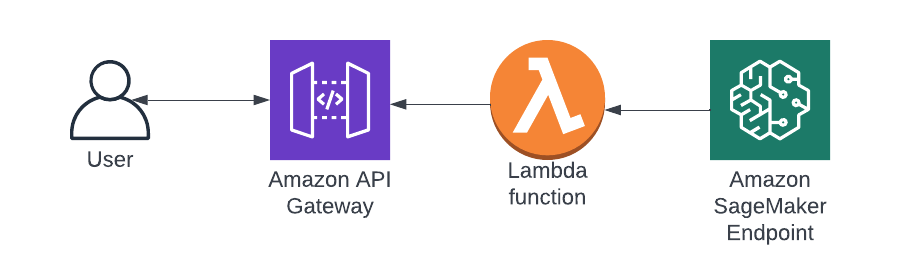


### Create a Lambda Function 

You are going to use AWS Lambda Functions as your backend to interact with the SageMaker endpoint we deployed. 
1. Navigate to https://nasa-impact.awsapps.com/start 
2. Login using the credentials used to set up your account
3. Click on `AWS accounts`
4. Click on `summerSchool`
5. Click on `Management Console`
6. Search for `lambda function` (Make sure we are in `us-west-2` region at the top right)
7. Click on `Create function` button
8. Select `Author from Scratch`
9. Provide a name for the function using the following template `<your name>-api-backend`
10. Change `Runtime` to `Python 3.8`
11. Click on `Change default execution role`
12. Select `Use an existing role`
13. Select `igarss-sagemaker-role` from the list
14. Click on `Create function`
15. Once on the lambda function page, click on `Layers`, and click on `Add a layer` (you will be adding `scipy` packages for your use case)
16. Choose `AWS layers`
17. Choose `AWSLambda-Python38-SciPy1x` and latest version
18. Click `Add`
19. On the code section of the lambda function page, paste the following code:


```
import os
import io
import boto3
import json
import csv
import numpy as np

# grab environment variables
ENDPOINT_NAME = <YOUR_ENDPOINT_NAME>
runtime= boto3.client('runtime.sagemaker')

def download_and_load_data(payload):
    client = boto3.client('s3')
    client.download_file(
        "smoke-dataset-bucket", 
        payload, 
        '/tmp/test.npy'
    )
    print(os.path.exists('/tmp/test.npy'))
    return np.asarray([np.load('/tmp/test.npy')])


def lambda_handler(event, context):
    data = json.loads(json.dumps(event))

    data = download_and_load_data(data["file_name"])
    response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                       ContentType='application/json',
                                       Body=json.dumps(data.tolist()))
    os.remove('/tmp/test.npy')
    result = json.loads(response['Body'].read().decode())
    print(result)
    return {
        'statusCode': 200,
        'headers': {'Content-Type': 'application/json'},
        'body': json.dumps(result)
    }

```


20. Update the `ENDPOINT_NAME` to reflect your endpoint: `<name>-prediction-endpoint`.
21. Deploy the changes
22. Click on `Configurations`
23. Click on `General` and then `Edit`
25. Change timeout to `5 min` from `3 sec`
26. Click `Save`

### Add API endpoint

Once the lambda function is set up, you can tie it together with API gateway.
1. In the search bar, search for `API gateway`
2. Click `Create API`
3. In the first `REST API` option, click `Build`
4. Provide an API name, format: `<your-name>-inference-api`
5. Click `Create API`
6. In the API page, click on `Action` and select `Create Method`
7. Select `POST` from the list and click on the tick button beside it
8. In the lambda function, type the lambda function name you created on the previous step
9. Click `Save`
9. Click `Ok` on the dialog box
10. Click on `Actions`
11. Click on `Deploy API`
12. Select `New stage`
13. Give a new name `<name>-dev`
14. Click on `Deploy`


### Infer
Because of limitations on AWS API endpoints, you are not allowed to upload files more than 6 MB. To circumvent this issue, you will leverage S3 bucket to host the test data. You will follow the following steps for inferencing purposes:
1. Upload test data into S3 bucket that the API has access to
2. Call inference API with the file we uploaded to the S3 bucket
3. Visualize the results

#### 1. Upload tet data into S3 bucket that the API has access to

##### To upload the files into the S3 bucket, you can take two different approaches:
1. Directly upload the files into the S3 bucket using the AWS console
2. Use console to upload the files


##### Direct upload to S3 Bucket:
1. Navigate to https://nasa-impact.awsapps.com/start 
2. Login using the credentials used to set up your account
3. Click on `AWS accounts`
4. Click on `summerSchool`
5. Click on `Management Console`
6. From the search bar in the AWS console, search for `S3` and click it
7. Click on `smoke-dataset-bucket`
8. Create a folder with your name (if not already there)
9. Click on the folder you created
10. Upload the file you want to test to the folder (drag drop or select the file using the UI)

##### Use Signed URL:
1. Navigate to https://nasa-impact.awsapps.com/start 
2. Login using the credentials used to set up your account
3. Click on `AWS accounts`
4. Click on `summerSchool`
5. Click on `Command Line or Programmatic Access`
6. Copy the `AWS_ACCESS_KEY_ID`, `AWS_SECRET_ACCESS_KEY`, and `AWS_SESSION_TOKEN`
7. Update the corresponding variables in the notebook cell
8. Run the cell with `generate_signed_url` method definition
9. Set the variable `test_filename` with `<your name>/<your test filename>`
9. Call `generate_signed_url` method with `test_filename` as the parameter: Eg: `signed_url = generate_signed_url("iksha/test.tif")`
10. Upload corresponding file from your local machine using curl `!curl --request PUT --upload-file <file path to upload> "{signed_url}"`


#### 2. Call inference API with the file you uploaded to the S3 bucket

Once the files are uploaded you infer using the API.
1. Run cell with `infer` method definition
2. Call `infer` method with the `test_filename` and assign to a variable. (e.g.: `predictions = infer(test_filename)`

#### 3. Visualize the results

Visualize the results using `visualize` method. Pass the `test_filename` and `predictions` to the method to view results.

In [ ]:
%cd /p/project/training2206/<username>/pixel-detector/
%pwd
%pip install -r requirements.txt

## Restart Kernel
Kernel > Restart Kernel

In [ ]:
%cd /p/project/training2206/<username>/pixel-detector/notebooks/
import boto3 
import requests
import numpy as np
import rasterio
import tempfile
from matplotlib import pyplot as plt
import numpy as np
import rasterio
import json

In [ ]:
AWS_ACCESS_KEY_ID=<your-key-id>
AWS_SECRET_ACCESS_KEY=<secret-access-key>
AWS_SESSION_TOKEN=<your-session-token>

BUCKET_NAME = 'smoke-dataset-bucket'

def generate_signed_url(filename):
    """
    Method to generate signed url to upload files into s3 bucket.
    ARGs:
        filename: Upload filename
    Returns: 
        Signed URL for file upload 
    """
    session = boto3.session.Session(
            aws_access_key_id=AWS_ACCESS_KEY_ID,
            aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
            aws_session_token=AWS_SESSION_TOKEN
        )
    s3_client = session.client('s3')
    response = s3_client.generate_presigned_post(
                Bucket = BUCKET_NAME,
                Key = f'<username>/{filename}'
        )
    return response

In [ ]:
def upload_np_from_geotiff(geotiff_file):
    """
    Method to convert the tif files to numpy files that the model 
    can predict from, and upload the said file using the signed url
    Args:
        geotiff_file: File to convert to geotiff
        
    """
    with rasterio.open(geotiff_file) as src:
        data = src.read()
        np.save('tmp.npy', np.moveaxis(data[:-1], 0, -1))
        upload_file_name = geotiff_file.split("/")[-1].replace("tif", "npy")
        response = generate_signed_url(f'inference_images/{upload_file_name}')
        response = requests.post(
            response['url'],
            data = response['fields'],
            files={'file': open('tmp.npy', 'rb')}
        )
        print(f'uploaded {upload_file_name}')
        return upload_file_name

    

## Upload inference files to s3

In [ ]:
from glob import glob

infer_files_path = "../data/images/wmts/inference/"
files_list = glob(infer_files_path+'*.tif')
uploaded_files = []

for idx, file_name in enumerate(files_list):
    uploaded_files.append(upload_np_from_geotiff(file_name))

In [ ]:
URL = "<API-endpoint-url>"

def infer(file_name):
    """
    Method to infer using the API endpoint
    Args:
        file_name: File path in S3 that was uploaded.
    """
    response = requests.post(URL, json={"file_name": file_name})
    response.raise_for_status()
    result = response.json()
    predictions = json.loads(result['body'])
    return np.asarray(predictions['predictions'])
    

In [ ]:
def convert_rgb(img):
    """
    Convert passed list of bands to proper RGB image for visualization purposes
    Args:
        img: numpy array of GOES data (6 bands)
    """
    red = img[:, :, 1].astype('uint8')
    blue = img[:, :, 0].astype('uint8')
    pseudo_green = img[:, :, 2].astype('uint8')
    height, width = red.shape

    img = np.moveaxis(
        np.array([red, pseudo_green, blue]), 0, -1
    )

    return img

def visualize(filename, predictions):
    """
    Method to visualize the results alongside the test data
    ARGs:
       filename: Name of the test file (local path) 
       predictions: response from the `infer` method for the corresponding file name.
    """
    preds = np.asarray(predictions) * 255
    raster = rasterio.open(filename).read()
    img = convert_rgb(raster)
    plt.imshow(img, preds[0])
    raster.close()


## visualizing the uploaded files

In [ ]:
import boto3
import io 
import numpy.ma as ma

session = boto3.session.Session(
        aws_access_key_id=AWS_ACCESS_KEY_ID,
        aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
        aws_session_token=AWS_SESSION_TOKEN
    )

s3_client = session.client('s3')

for uploaded_file_name in uploaded_files:
    key = f'<username>/inference_images/{uploaded_file_name}'

    # rewind the file
    # f.seek(0)
    tif_file = uploaded_file_name.replace('.npy','.tif')
    arr = rasterio.open(f'../data/images/wmts/inference/{tif_file}').read()
    arr = np.moveaxis(arr, 0, -1)
    f, ax = plt.subplots(1, 2)
    ax[0].imshow(convert_rgb(arr).astype('uint8'))
    ax[1].imshow(convert_rgb(arr).astype('uint8'))
    predictions = infer(key)[0, :, :, 0]  * 255
    ax[1].imshow(
        ma.masked_where(
            predictions < 50, predictions
        ),
        alpha=0.95,
        cmap='Oranges'
    )
    plt.show()